## I.SETUP 
 * S3 Bucket
 * Preconf. IAM req.
 * Import req. packages

In [1]:
import pandas as pd

In [2]:
# import source data from AWS S3

bucket='anz-dataset'
data_key = 'anz.csv'
data_path = 's3://{}/{}'.format(bucket, data_key)

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,...,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,...,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


In [5]:
# import libraries
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
import datetime as dt
import pandas as pd
from datetime import datetime, timedelta
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer

## II. Data Discovery & Data Cleansing

In [7]:
# encounter info of this data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             12043 non-null  object 
 1   card_present_flag  7717 non-null   float64
 2   bpay_biller_code   885 non-null    object 
 3   account            12043 non-null  object 
 4   currency           12043 non-null  object 
 5   long_lat           12043 non-null  object 
 6   txn_description    12043 non-null  object 
 7   merchant_id        7717 non-null   object 
 8   merchant_code      883 non-null    float64
 9   first_name         12043 non-null  object 
 10  balance            12043 non-null  float64
 11  date               12043 non-null  object 
 12  gender             12043 non-null  object 
 13  age                12043 non-null  int64  
 14  merchant_suburb    7717 non-null   object 
 15  merchant_state     7717 non-null   object 
 16  extraction         120

In [8]:
# 12043 entries and 23 columns

In [9]:
# calc. missing values

val_mis = df.isnull().sum()
val_mis_prcnt = round((df.isnull().sum() / (len(df))*100), 2)  #round of 2 dec.

print(f"Missing Value is {val_mis}") 
print(f"Missing Percentage is {val_mis_prcnt}")

Missing Value is status                   0
card_present_flag     4326
bpay_biller_code     11158
account                  0
currency                 0
long_lat                 0
txn_description          0
merchant_id           4326
merchant_code        11160
first_name               0
balance                  0
date                     0
gender                   0
age                      0
merchant_suburb       4326
merchant_state        4326
extraction               0
amount                   0
transaction_id           0
country                  0
customer_id              0
merchant_long_lat     4326
movement                 0
dtype: int64
Missing Percentage is status                0.00
card_present_flag    35.92
bpay_biller_code     92.65
account               0.00
currency              0.00
long_lat              0.00
txn_description       0.00
merchant_id          35.92
merchant_code        92.67
first_name            0.00
balance               0.00
date                  0.00
gen

In [10]:
# expecting null or close to a single common value
df.currency.value_counts()

AUD    12043
Name: currency, dtype: int64

In [11]:
df.currency.unique()

array(['AUD'], dtype=object)

In [12]:
df.drop(['currency'], axis = 1, inplace = True) #column drop with true bool

In [13]:
df.bpay_biller_code.value_counts()

0                                        883
 LAND WATER & PLANNING East Melbourne      1
 THE DISCOUNT CHEMIST GROUP                1
Name: bpay_biller_code, dtype: int64

In [14]:
# 2 values only represent 0.016%, which is not ideal. Column will be dropped as well
df.drop(['bpay_biller_code'], axis = 1, inplace = True)

In [15]:
df.merchant_code.value_counts()

0.0    883
Name: merchant_code, dtype: int64

In [16]:
df.drop(['merchant_code'], axis = 1, inplace=True)

In [17]:
df.movement.value_counts()

debit     11160
credit      883
Name: movement, dtype: int64

In [18]:
# debit     11160   credit      883

In [19]:
df.extraction.value_counts()

2018-09-03T11:00:00.000+0000    10
2018-10-02T17:00:00.000+0000     9
2018-10-19T13:00:00.000+0000     9
2018-09-04T17:00:00.000+0000     9
2018-09-17T11:00:00.000+0000     9
                                ..
2018-09-20T15:20:43.000+0000     1
2018-08-24T13:40:22.000+0000     1
2018-08-13T12:19:12.000+0000     1
2018-09-26T10:42:53.000+0000     1
2018-09-22T22:19:46.000+0000     1
Name: extraction, Length: 9442, dtype: int64

In [20]:
df.date.value_counts()

9/28/2018     174
8/17/2018     172
10/5/18       168
10/17/2018    162
9/14/2018     161
             ... 
8/6/18         99
8/20/2018      97
10/23/2018     96
10/8/18        95
10/30/2018     89
Name: date, Length: 91, dtype: int64

In [21]:
df.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

In [22]:
# PAY/SALARY     883 while others are money spent, Interbank/Phone Bank can be an option to be considered

In [23]:
# check if any dups. as init.

df.duplicated().sum()

0

In [24]:
df.account.duplicated().sum()

11943

In [25]:
# 12043 - 100 = 1194 -> there are 100 accounts

In [26]:
df.country.value_counts()

Australia    12043
Name: country, dtype: int64

In [27]:
df.drop(['country'], axis = 1, inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             12043 non-null  object 
 1   card_present_flag  7717 non-null   float64
 2   account            12043 non-null  object 
 3   long_lat           12043 non-null  object 
 4   txn_description    12043 non-null  object 
 5   merchant_id        7717 non-null   object 
 6   first_name         12043 non-null  object 
 7   balance            12043 non-null  float64
 8   date               12043 non-null  object 
 9   gender             12043 non-null  object 
 10  age                12043 non-null  int64  
 11  merchant_suburb    7717 non-null   object 
 12  merchant_state     7717 non-null   object 
 13  extraction         12043 non-null  object 
 14  amount             12043 non-null  float64
 15  transaction_id     12043 non-null  object 
 16  customer_id        120

In [29]:
df.card_present_flag.value_counts()

1.0    6194
0.0    1523
Name: card_present_flag, dtype: int64

In [30]:
df.status.value_counts()

authorized    7717
posted        4326
Name: status, dtype: int64

In [31]:
df.dtypes

status                object
card_present_flag    float64
account               object
long_lat              object
txn_description       object
merchant_id           object
first_name            object
balance              float64
date                  object
gender                object
age                    int64
merchant_suburb       object
merchant_state        object
extraction            object
amount               float64
transaction_id        object
customer_id           object
merchant_long_lat     object
movement              object
dtype: object

In [33]:
# float, int = card present, age, balance, amount, balance (possibility for measurement axis)

## III. Data Insights

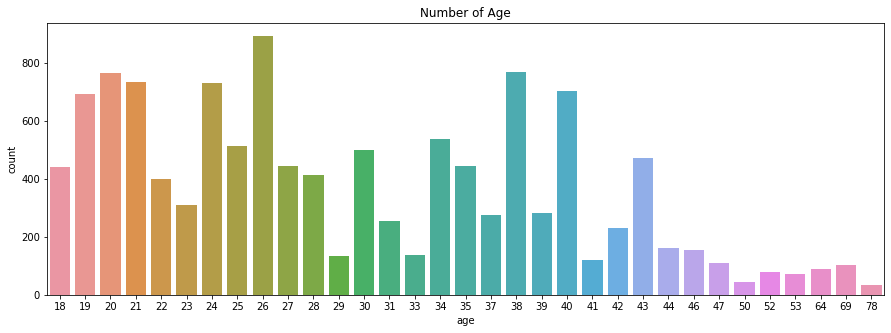

In [38]:
plt.figure(figsize=[15, 5])
plt.title('Number of Age')
sb.countplot(df['age'])

In [36]:
# majority are from age 20-40

In [39]:
# explore if there's any pattern from date
df['date'] = pd.to_datetime(df['date'])

In [40]:
df['day']= df['date'].dt.day_name()
df['month'] = df['date'].dt.month_name()
df['year'] = df['date'].dt.year

In [41]:
df.year.value_counts()

2018    12043
Name: year, dtype: int64

In [42]:
# all records in 2018 therefore the record will be dropped

df.drop(['year'], axis = 1 , inplace = True)

(array([3943.,    0.,    0.,    0.,    0., 4013.,    0.,    0.,    0.,
        4087.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

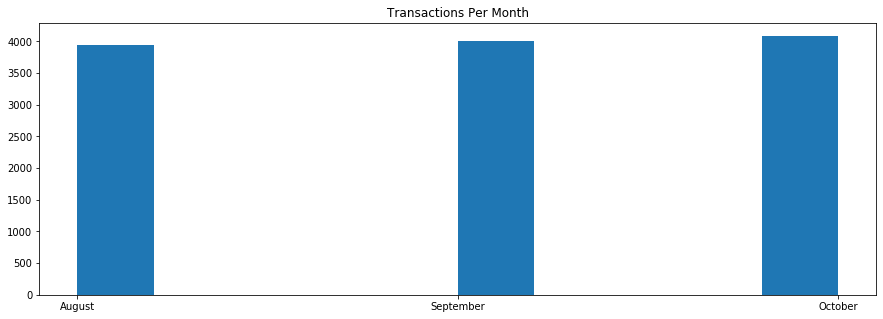

In [43]:
plt.figure(figsize=[15, 5])
plt.title('Transactions Amount Per Month')
plt.hist(df['month'])

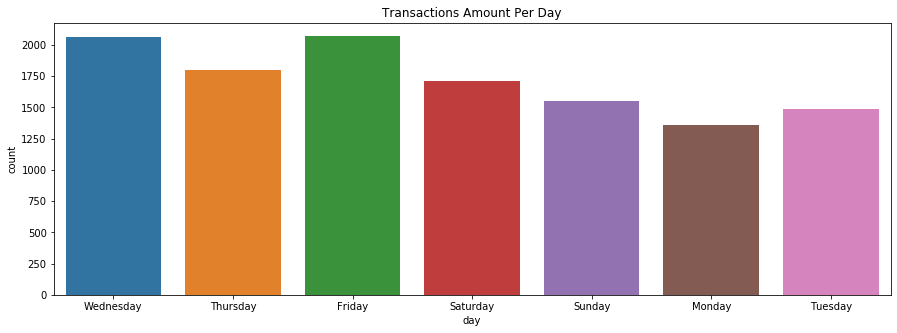

In [60]:
plt.figure(figsize=[15, 5])
plt.title('Transactions Amount Per Day')
sb.countplot(df['day'])

In [45]:
# more activities throughout from the middle of the week to early wknds

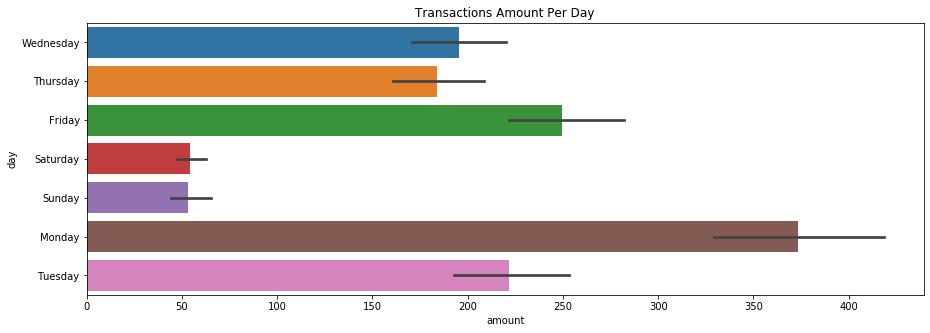

In [61]:
plt.figure(figsize=[15, 5])
plt.title('Transactions Amount Per Day')
sb.barplot(x = 'amount', y='day', data = df)

In [47]:
# more spent during weekdays than weekend

<Figure size 1080x360 with 0 Axes>

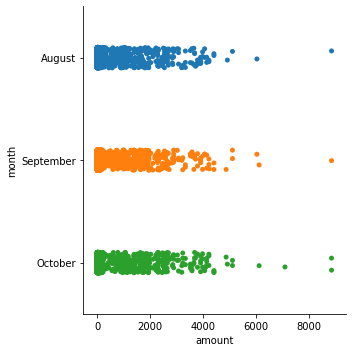

In [52]:
plt.figure(figsize=[15, 5])
sb.catplot(x = 'amount', y='month', data = df)

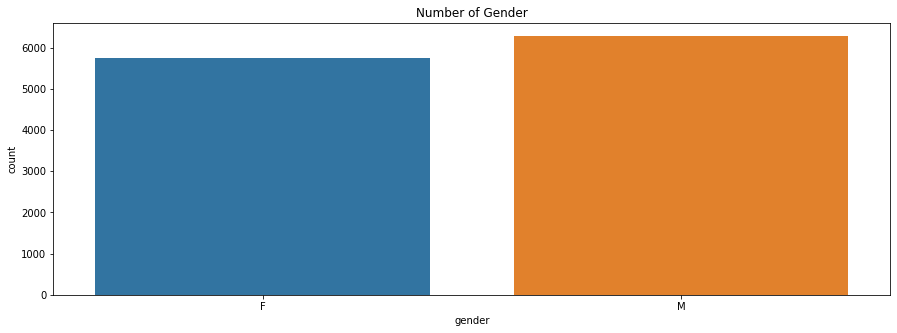

In [53]:
plt.figure(figsize=[15, 5])
plt.title('Number of Gender')
sb.(df['gender'])

In [54]:
# get some stats
df.amount.describe()

count    12043.000000
mean       187.933588
std        592.599934
min          0.100000
25%         16.000000
50%         29.000000
75%         53.655000
max       8835.980000
Name: amount, dtype: float64

In [55]:
df.txn_description.describe()

count         12043
unique            6
top       SALES-POS
freq           3934
Name: txn_description, dtype: object

In [56]:
df.balance.describe()

count     12043.000000
mean      14704.195553
std       31503.722652
min           0.240000
25%        3158.585000
50%        6432.010000
75%       12465.945000
max      267128.520000
Name: balance, dtype: float64

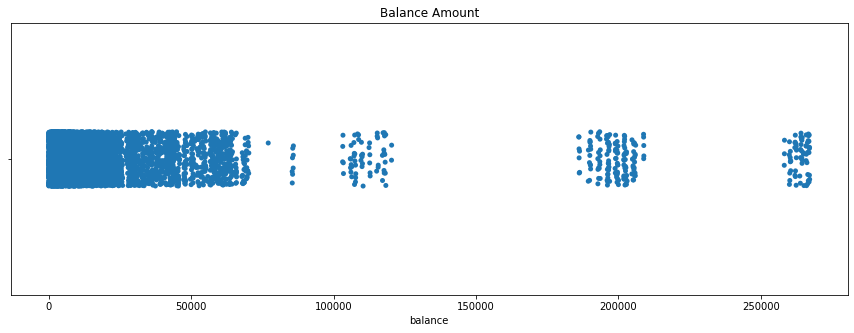

In [57]:
plt.figure(figsize=[15, 5])
plt.title('Balance Amount')
sb.stripplot(x = 'balance', data = df)

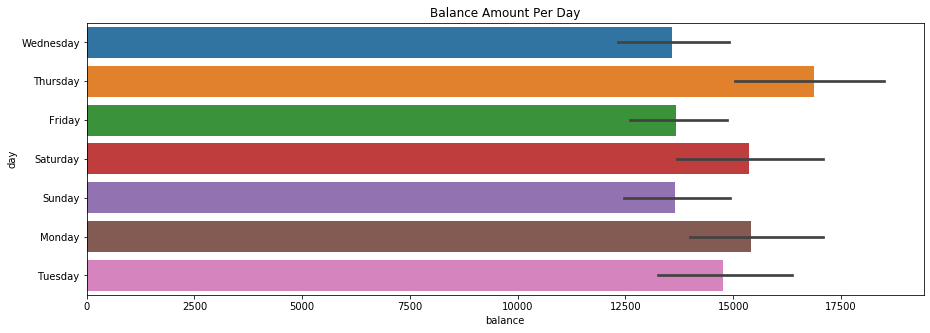

In [58]:
plt.figure(figsize=[15, 5])
plt.title('Balance Amount Per Day')
sb.barplot(x = 'balance', y='day', data = df)

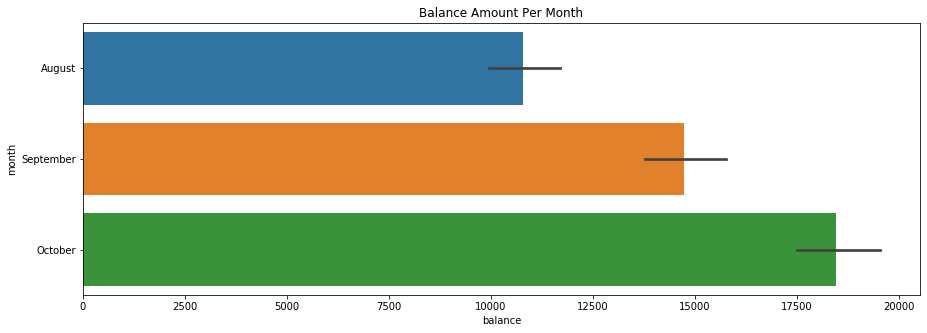

In [59]:
plt.figure(figsize=[15, 5])
plt.title('Balance Amount Per Month')
sb.barplot(x = 'balance', y='month', data = df)

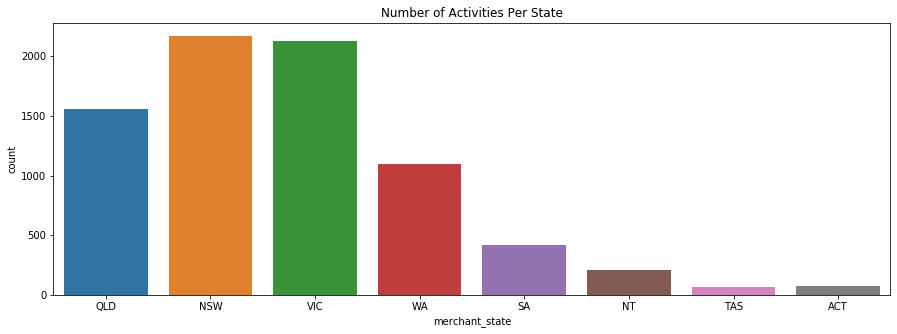

In [79]:
plt.figure(figsize=[15, 5])
plt.title('Number of Activities Per State')
sb.countplot(df['merchant_state'])

### Data Insight Results
  * All records occurred in August 2018 - October 2018
  * Age Majority is between 20-40
  * More transaction activities throughout from the middle of the week to early weekends
  * More transaction amount occurred during weekdays than weekend (Spending and Salary Payment)
  * Male/Female ratio was similar (52% M, 48% F)

## IV. Correlation Heatmap

In [86]:
customers = df.customer_id.unique()  # based on customer's measurement

# create a df to initiate
df_cus_profile = pd.DataFrame(columns=["customer_id", "annual salary", "age", "gender", "state", "transaction_number",
                                       "min_transaction_amount", "avg_transaction_amount", "max_transaction_amount", ]) 

In [87]:
# iterate customers with the below condition

for count, cs_id in enumerate(customers):  
    df_cus = df[(df.customer_id == cs_id) & (df.txn_description == 'PAY/SALARY')]
    
    # calculate annual salary
    pay_period = pd.to_datetime(df_cus.date).diff().mean() / pd.Timedelta('86400s')
    pay_amount = df_cus.amount.mean()
    daily_rate = pay_amount / pay_period
    annual_rate = daily_rate * 365
    
    # store the info
    df_cus_profile.loc[count, ["customer_id", "annual salary" ]] = [id, annual_rate]

In [88]:
# also iterate customers with nonreq. where salary needs to be included

for count, cs_id in enumerate(customers):
  df_cus = df[df.customer_id == cs_id]
  
  # rename to state
  state = df_cus["merchant_state"].mode()[0]
  
  # calculate the number of transactions to check if any pattern matches
  trans_number = df_cus["transaction_id"].count()
  # calculate the min trans amount
  min_trans_amount = df_cus["amount"].min()
  # calculate the max transaction amount during a certain time of period
  avg_trans_amount = df_cus["amount"].mean()
  max_trans_amount = df_cus["amount"].max()
    
  # get age
  age = df_cus.age.mean()
  # get gender
  gender = df_cus["gender"].mode()[0]
    
  # store the info
  df_cus_profile.loc[count, ["state", "transaction_number", "min_transaction_amount", "avg_transaction_amount", 
                             "max_transaction_amount", "age", "gender"]] = [state, trans_number,min_trans_amount,
                                                                            avg_trans_amount, max_trans_amount, age, gender]

In [89]:
df.dtypes

status                       object
card_present_flag           float64
account                      object
long_lat                     object
txn_description              object
merchant_id                  object
first_name                   object
balance                     float64
date                 datetime64[ns]
gender                       object
age                           int64
merchant_suburb              object
merchant_state               object
extraction                   object
amount                      float64
transaction_id               object
customer_id                  object
merchant_long_lat            object
movement                     object
day                          object
month                        object
dtype: object

In [90]:
# to prevent dtypes error and for consistency, we'll transform the data types

df_cus_profile["annual salary"] = df_cus_profile["annual salary"].astype(float)
df_cus_profile["state"] = pd.get_dummies(df_cus_profile["state"], drop_first=True)
df_cus_profile["gender"] = pd.get_dummies(df_cus_profile["gender"], drop_first=True)
df_cus_profile["age"] = df_cus_profile["age"].astype(float)
df_cus_profile["avg_transaction_amount"] = df_cus_profile["avg_transaction_amount"].astype(float)
df_cus_profile["transaction_number"] = df_cus_profile["transaction_number"].astype(float)
df_cus_profile["min_transaction_amount"] = df_cus_profile["min_transaction_amount"].astype(float)
df_cus_profile["max_transaction_amount"] = df_cus_profile["max_transaction_amount"].astype(float)

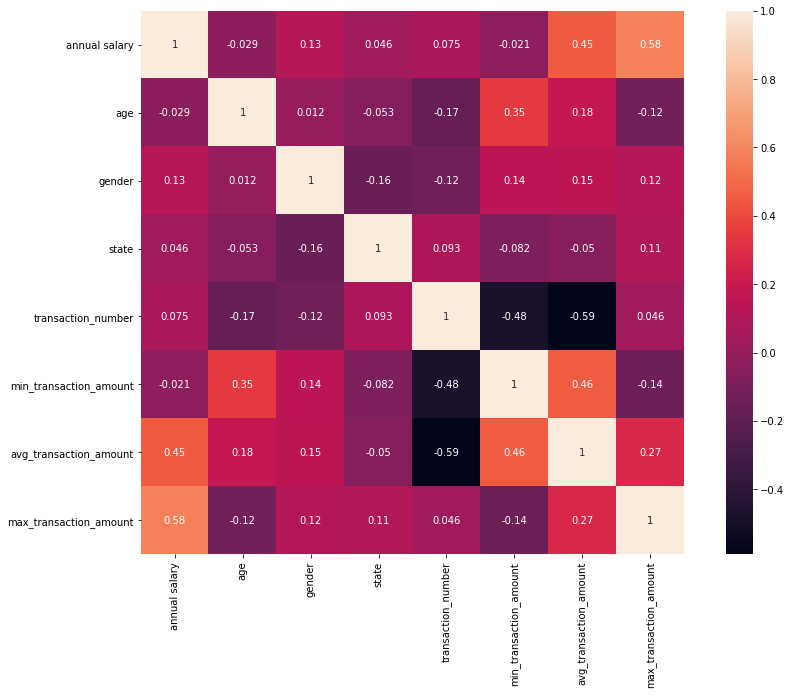

In [91]:
# provide the result for this correlation heatmap

plt.figure(figsize=(15,10))
corrMatrix = df_cus_profile.corr(method='pearson', min_periods=0)
sb.heatmap(corrMatrix, annot=True, square=True)

### There seems to be a correlation between
 * Annual Salary and Max. Transaction Amount
 * Annual Salary and Average Transaction Amount
 * Age and Minimum Transaction Amount
 * Average Transaction Amount to Minimum Transaction Amount

## V. Linear Regression Predictive Analysis
 * Decision Tree (Train, Test, and Predict Measurement) <y = mx+b>

In [152]:
from sklearn import datasets, linear_model, tree, metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split as tt_split

In [153]:
# split data 80% Training, 20% Test

train, test = tt_split(df_cus_profile, test_size = 0.2)

In [154]:
# def var. for train and test

x_train = train[["age", "min_transaction_amount", "max_transaction_amount"]]
y_train = train["annual salary"]

x_test = test[["age", "min_transaction_amount", "max_transaction_amount"]]
y_test = test["annual salary"]

In [155]:
# train model
rm = linear_model.LinearRegression()
rm.fit(x_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [156]:
# coeff. determination
rm.score (x_train, y_train)

0.36360553632088377

In [157]:
## interpret coefficient
# print y-intercept
print(rm.intercept_)

36995.40864776178


In [158]:
# prints beta coefficient 
print(rm.coef_)

[108.09822091 146.37188442  11.22568182]


In [159]:
# predict based on the given model

y_pred = rm.predict(x_test)

In [160]:
## eval. the model using MAE, MSE, RMSE

print("MAE Result is ", metrics.mean_absolute_error(y_test, y_pred))
print("MSE Result is ", metrics.mean_squared_error(y_test, y_pred))
print("RMSE Result is ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE Result is  12453.730866882699
MSE Result is  356618843.919129
RMSE Result is  18884.35447451485


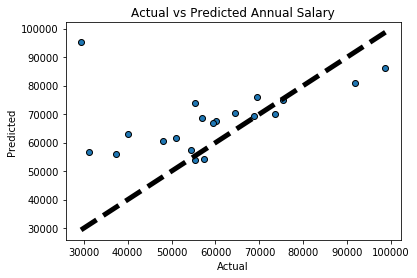

In [175]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--',lw=5)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted Annual Salary")
plt.show()

In [161]:
# remove the less x impact which is the max trans a

x_train2 = train[["age", "min_transaction_amount"]]
y_train2 = train["annual salary"]

x_test2 = test[["age", "min_transaction_amount"]]
y_test2 = test["annual salary"]

In [163]:
# train model2
rm = linear_model.LinearRegression()
rm.fit(x_train2, y_train2) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [164]:
# coeff. determination
rm.score (x_train2, y_train2)

0.0013909830336658047

In [165]:
print(rm.intercept_)

70994.52226245977


In [166]:
print(rm.coef_)

[   3.12124335 -253.66434209]


In [167]:
y_pred2 = rm.predict(x_test2)

In [168]:
## eval. the model using MAE, MSE, RMSE

print("MAE Result is ", metrics.mean_absolute_error(y_test2, y_pred2))
print("MSE Result is ", metrics.mean_squared_error(y_test2, y_pred2))
print("RMSE Result is ", np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)))

MAE Result is  16757.927953088278
MSE Result is  421156417.2362443
RMSE Result is  20522.0958295259


#### The Coefficient of Determination was around 0.36 while RMSE exceeded over 2000
#### This concludes how Linear Regression Model is inefficient to use

## VI. Decision Predictive Analysis
 * Decision Tree (Train, Test, and Predict Measurement)

In [176]:
# import relevant packages

from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_iris # to enhance influential discovery and finding impact

In [180]:
iris = load_iris()

In [177]:
# initialize the model
model =  DecisionTreeRegressor(max_depth=5,random_state=0)

In [182]:
model.fit(x_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [183]:
# coeff. termination 
model.score(x_train, y_train)

0.8102756001809144

In [186]:
# predict the model
y_predict= model.predict(x_test)

In [187]:
## eval. the model using MAE, MSE, RMSE

print("MAE Result is ", metrics.mean_absolute_error(y_test, y_predict))
print("MSE Result is ", metrics.mean_squared_error(y_test, y_predict))
print("RMSE Result is ", np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

MAE Result is  16458.262715105266
MSE Result is  476533563.2350582
RMSE Result is  21829.64871991893


In [193]:
# graphically show the tree model
from sklearn.tree import export_graphviz
from IPython.display import Image 

In [194]:
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

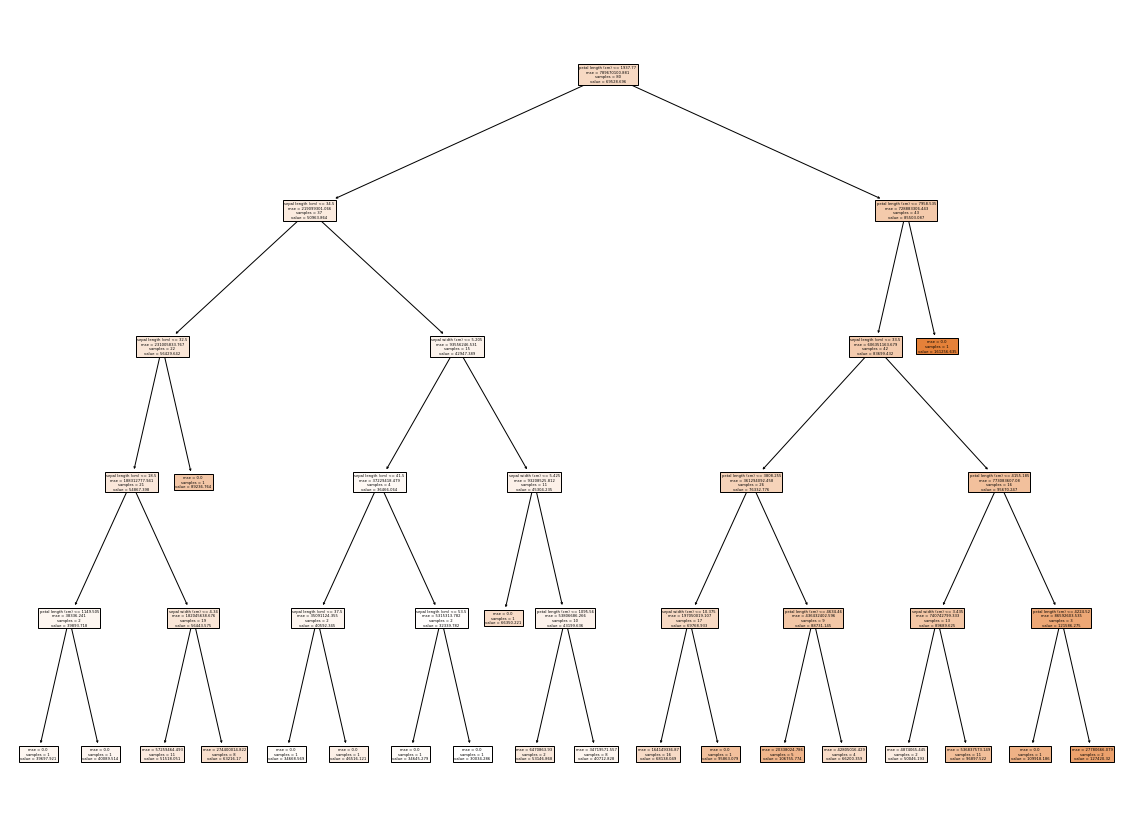

In [208]:
fig = plt.figure(figsize=(20,15))
graph = tree.plot_tree(model, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)

#### Decision Tree pulls up the coefficient determiniation up to 0.81.
#### This is a high value, which indicates the relationship with y-axis annual salary
#### However, the RMSE results is still 20000, close to the Linear Regression Model.

## VII. Conclusion
### This concludes how Decision Tree Model and Linear Regression Models are inefficient to use.
### There are 2 recommendations at this stage:
 * Revisit Analysis Model to tweak X-axis and Y-axis
 * Apply other scientific models for further analysis
#### ** Running parallelly can be cost 

In [221]:
import sagemaker

sagemaker_session = sagemaker.Session(default_bucket='anz-dataset')
upload_data = sagemaker_session.upload_data(path='data-demo.ipynb')

print('upload_data : {}'.format(upload_data))

upload_data : s3://anz-dataset/data/data-demo.ipynb


In [222]:
import sagemaker

sagemaker_session = sagemaker.Session(default_bucket='anz-dataset')
upload_data = sagemaker_session.upload_data(path='final.csv')

print('upload_data : {}'.format(upload_data))

upload_data : s3://anz-dataset/data/final.csv


In [224]:
df.to_csv('final.pdf')